In [1]:
%matplotlib notebook
# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
import pyproj
import shapely
import copy
from uafgi import gicollections,cfutil,glacier,gdalutil,shputil,pdutil
import uafgi.data.ns642
import netCDF4
import matplotlib.pyplot as plt
import uafgi.data.wkt
import uafgi.data.w21 as d_w21
map_wkt = uafgi.data.wkt.nsidc_ps_north
pd.set_option("display.max_rows", 30, "display.max_columns", None)
pd.set_option("display.max_rows", 200, "display.max_columns", None)

,fid,id,terminus,loc,key
0,0,None,None,LINESTRING (144041.8608331161 -2950869.9926318...,0
1,1,None,None,LINESTRING (143607.676485015 -2950518.51006429...,1
2,2,None,None,LINESTRING (143214.8430272093 -2950063.6502710...,2
3,3,None,None,LINESTRING (142697.9568985179 -2949402.0360263...,3
4,4,None,None,LINESTRING (142181.070769827 -2948864.47445248...,4
5,5,None,None,LINESTRING (141850.2636474647 -2948326.9128786...,5
6,6,None,None,LINESTRING (141374.7284090685 -2947954.7548659...,6


In [100]:
# For now, do this for just 1 glacier
#w21_glacier_id = 199   # Sverdrup

w21_glacier_id = 58   # Rimfaxe
select = pdutil.ExtDf.read_pickle(uafgi.data.join_outputs('stability/01_select.dfx'))
select.df.columns

Index(['w21t_Glacier', 'w21t_date_termini', 'w21t_glacier_number', 'w21t_tloc',
       'w21_popular_name', 'w21_greenlandic_name', 'w21_coast', 'w21_category',
       'w21_Qr', 'w21_Qf', 'w21_Qm', 'w21_Qs', 'w21_Qc_inferred', 'w21_qm',
       'w21_qf', 'w21_qc', 'w21_mean_depth', 'w21_min_depth',
       'w21_quality_str', 'w21_area_grounded_1992_2017',
       'w21_area_grounded_1992_1997', 'w21_area_grounded_1998_2007',
       'w21_area_grounded_2008_2017', 'w21_mean_fjord_width',
       'w21_length_grounded_1992_2017', 'w21_length_grounded_1992_1997',
       'w21_length_grounded_1998_2007', 'w21_length_grounded_2008_2017',
       'w21_ocean_model_sample_area', 'w21_mean_TF_1992-2017',
       'w21_mean_TF_1992-1997', 'w21_mean_TF_1998-2007',
       'w21_mean_TF_2008-2017', 'w21_subglacial_discharge_1992_2017',
       'w21_subglacial_discharge_1992_1997',
       'w21_subglacial_discharge_1998_2007',
       'w21_subglacial_discharge_2008_2017', 'w21_mean_xsection_area',
       'w21_mean_

In [101]:
selrow = select.df.set_index('w21t_glacier_number').loc[w21_glacier_id]
selrow

w21t_Glacier                                                                    Rimfaxe
w21t_date_termini                     [(2009-07-14 00:00:00, LINESTRING (144506 -295...
w21t_tloc                                   POINT (145767.3939974457 -2950605.91954023)
w21_popular_name                                                            Rimfaxe Gl.
w21_greenlandic_name                                                                   
w21_coast                                                                            SE
w21_category                                                                         CR
w21_Qr                                                                             0.09
w21_Qf                                                                            -5.83
w21_Qm                                                                             1.16
w21_Qs                                                                              0.0
w21_Qc_inferred                 

In [102]:
selrow.w21_data_fname

'Rimfaxe Data.nc'

In [103]:
tpl = uafgi.data.join_outputs('wood2021', 'velocities', 'vel_{}_2011_2020').format(selrow.ns481_grid)
velocity_file = tpl+'.nc'
sigma_file = tpl+'_sigma.nc'
bedmachine_file = uafgi.data.join_outputs('bedmachine', 'BedMachineGreenland-2017-09-20_{}.nc'.format(selrow.ns481_grid))
sigma_file

'outputs/wood2021/velocities/vel_E63.35N_2011_2020_sigma.nc'

In [104]:
selrow


    

w21t_Glacier                                                                    Rimfaxe
w21t_date_termini                     [(2009-07-14 00:00:00, LINESTRING (144506 -295...
w21t_tloc                                   POINT (145767.3939974457 -2950605.91954023)
w21_popular_name                                                            Rimfaxe Gl.
w21_greenlandic_name                                                                   
w21_coast                                                                            SE
w21_category                                                                         CR
w21_Qr                                                                             0.09
w21_Qf                                                                            -5.83
w21_Qm                                                                             1.16
w21_Qs                                                                              0.0
w21_Qc_inferred                 

In [105]:
import datetime
date_termini = copy.copy(selrow.w21t_date_termini)

rftermini = shputil.read_df('RimfaxeRetreat.shp', wkt=map_wkt, shape0='terminus')
rftermini.df

for ix,row in rftermini.df.iterrows():
    dt = datetime.datetime(2020+ix,1,1)
    date_termini.append((dt,row['loc']))

#rftermini.df['loc']
date_termini

[(Timestamp('2009-07-14 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3750>),
 (Timestamp('2003-08-15 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3790>),
 (Timestamp('2004-08-01 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b37d0>),
 (Timestamp('2014-08-21 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3810>),
 (Timestamp('2010-08-02 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3850>),
 (Timestamp('2000-07-05 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3890>),
 (Timestamp('2007-07-25 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b38d0>),
 (Timestamp('2018-08-07 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3910>),
 (Timestamp('2001-07-08 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3950>),
 (Timestamp('2006-07-22 00:00:00'),
  <shapely.geometry.linestring.LineString at 0x1277b3990>),
 (Timestamp('1999-09-21 00:00:00'),
  <s

In [106]:
#importlib.reload(cfutil)
# Get velocity times
print('sigma_file ', sigma_file)
with netCDF4.Dataset(velocity_file) as nc:
    ntimes = len(nc.dimensions['time'])
    print('ntimes = {}'.format(ntimes))
    print(nc.variables['time'][:])
    times = cfutil.read_time(nc, 'time')
    time_bndss = cfutil.read_time(nc, 'time_bnds', unitvar='time')

# Get available terminus locations


sigma_file  outputs/wood2021/velocities/vel_E63.35N_2011_2020_sigma.nc
ntimes = 7
[   0.  366.  731. 1096. 1461. 1827. 2192.]


In [107]:
from uafgi.pism import flow_simulation
importlib.reload(flow_simulation)
itime = 0
#termini = [date_termini[0][1]]

date_termini.sort()
termini = [terminus for _,terminus in date_termini]
frs = flow_simulation.flow_rate3(selrow['ns481_grid'],
    bedmachine_file, selrow['fj_poly'],
    velocity_file,sigma_file,itime, termini,
    selrow['up_loc'])

In [115]:
import scipy.interpolate
from uafgi import dtutil
data = list()
for (date,terminus),fr in zip(date_termini,frs):
    data.append((date,terminus,fr.aflux,fr.sflux,fr.up_area))
#    print(date, fr.sflux/fr.aflux, fr)
fluxdf = pd.DataFrame(data, columns=('date','terminus','aflux','sflux','up_area'))
fluxdf['fluxratio'] = fluxdf.sflux/fluxdf.aflux
fluxdf['year'] = fluxdf['date'].map(dtutil.year_fraction)   # [a]

In [116]:
from uafgi import interputil
importlib.reload(interputil)
spl = interputil.spline_ma(fluxdf['year'].to_numpy(), fluxdf['up_area'].to_numpy(), dx_approx=1./12., ma_window=4.)
xs = np.linspace(2009.5,2026,100)
ys = spl.derivative()(xs)
plt.plot(xs,ys)

354 354
ma_npt =  48
307 307


In [117]:
#spl = scipy.interpolate.UnivariateSpline(fluxdf['year'], fluxdf['up_area'],s=0)

                    
plt.plot(xs,spl.derivative()(xs), 'g')
plt.show()

<IPython.core.display.Javascript object>


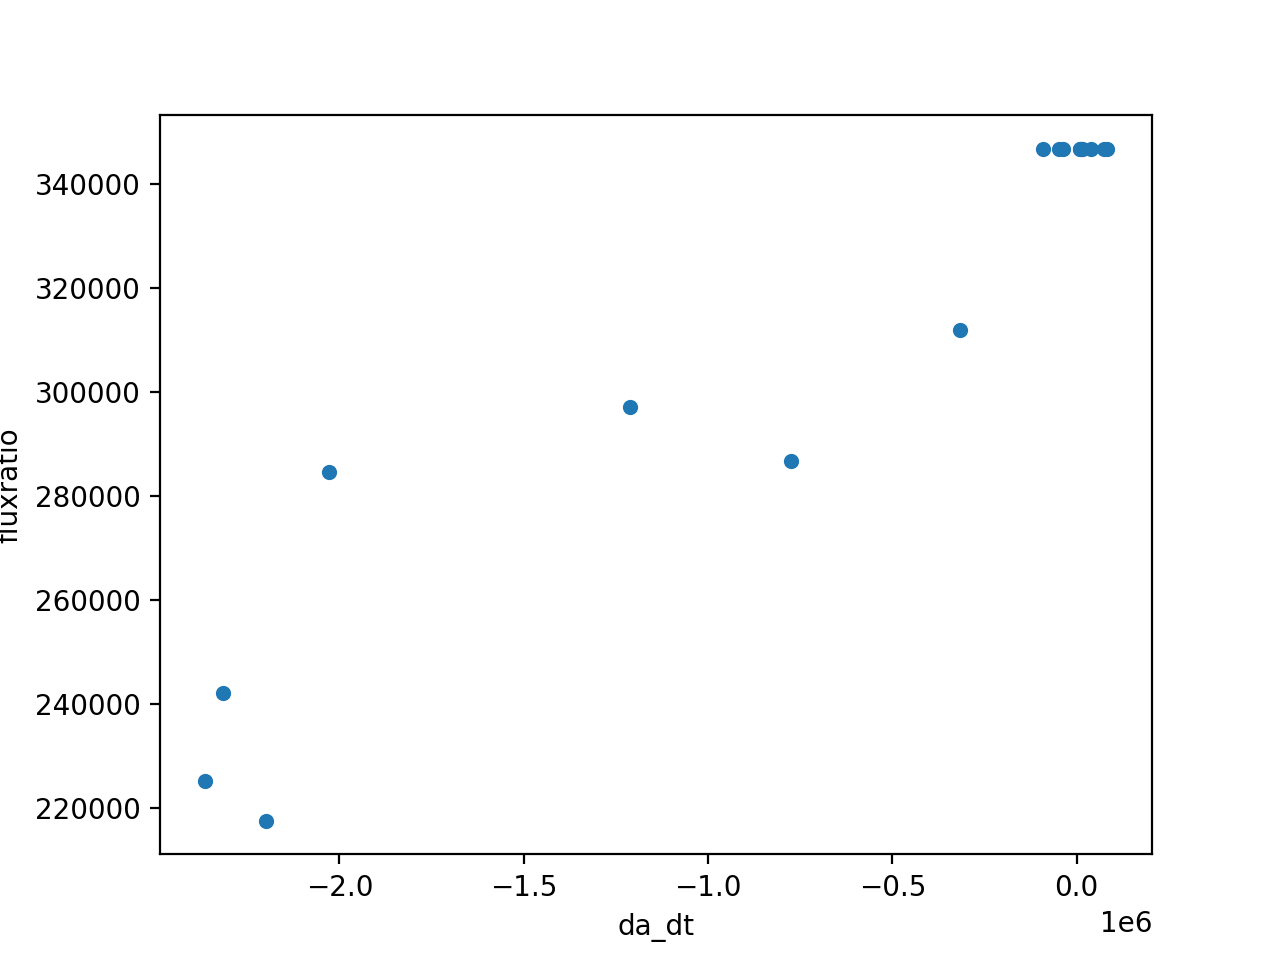

,date,terminus,aflux,sflux,up_area,fluxratio,year,da_dt
11,2009-07-14,"LINESTRING (144506 -2951190, 144529 -2951200, ...",0.172301,59735.816804,71940000.0,346693.901186,2009.531393,9.218372e+03
12,2010-08-02,"LINESTRING (144527 -2951240, 144557 -2951240, ...",0.172301,59735.816804,72020000.0,346693.901186,2010.583447,-4.912435e+04
13,2011-08-05,"LINESTRING (144583 -2951060, 144603 -2951060, ...",0.172301,59735.816804,72380000.0,346693.901186,2011.591667,7.486267e+04
14,2012-08-23,"LINESTRING (144538 -2951020, 144588 -2951030, ...",0.172301,59735.816804,72080000.0,346693.901186,2012.641963,-3.587197e+04
15,2013-08-18,"LINESTRING (144508 -2951180, 144517 -2951160, ...",0.172301,59735.816804,72060000.0,346693.901186,2013.627283,3.811668e+04
16,2014-08-21,"LINESTRING (144527 -2951260, 144540 -2951250, ...",0.172301,59735.816804,72120000.0,346693.901186,2014.635502,1.547897e+04
17,2015-08-24,"LINESTRING (144510 -2951200, 144528 -2951190, ...",0.172301,59735.816804,72010000.0,346693.901186,2015.643721,-9.125605e+04
18,2016-07-25,"LINESTRING (144534 -2951270, 144538 -2951250, ...",0.172301,59735.816804,72150000.0,346693.901186,2016.562728,1.447425e+04
19,2018-08-07,"LINESTRING (144507 -2951210, 144514 -2951190, ...",0.172301,59735.816804,72130000.0,346693.901186,2018.597146,9.901389e+03
20,2019-03-05,"LINESTRING (144465 -2951100, 144486 -2951090, ...",0.172301,59735.816804,72390000.0,346693.901186,2019.172603,8.204360e+04


In [120]:
spld = spl.derivative()

# Select only newer rows since delcine started
fluxdf = fluxdf[fluxdf['year'] >= 2009.5]

#fluxdf['da_dt'] = fluxdf['up_area'].diff() / fluxdf['year'].diff()
fluxdf['da_dt'] = fluxdf['year'].map(spld)
fluxdf.plot.scatter(x='da_dt', y='fluxratio')
fluxdf

<IPython.core.display.Javascript object>


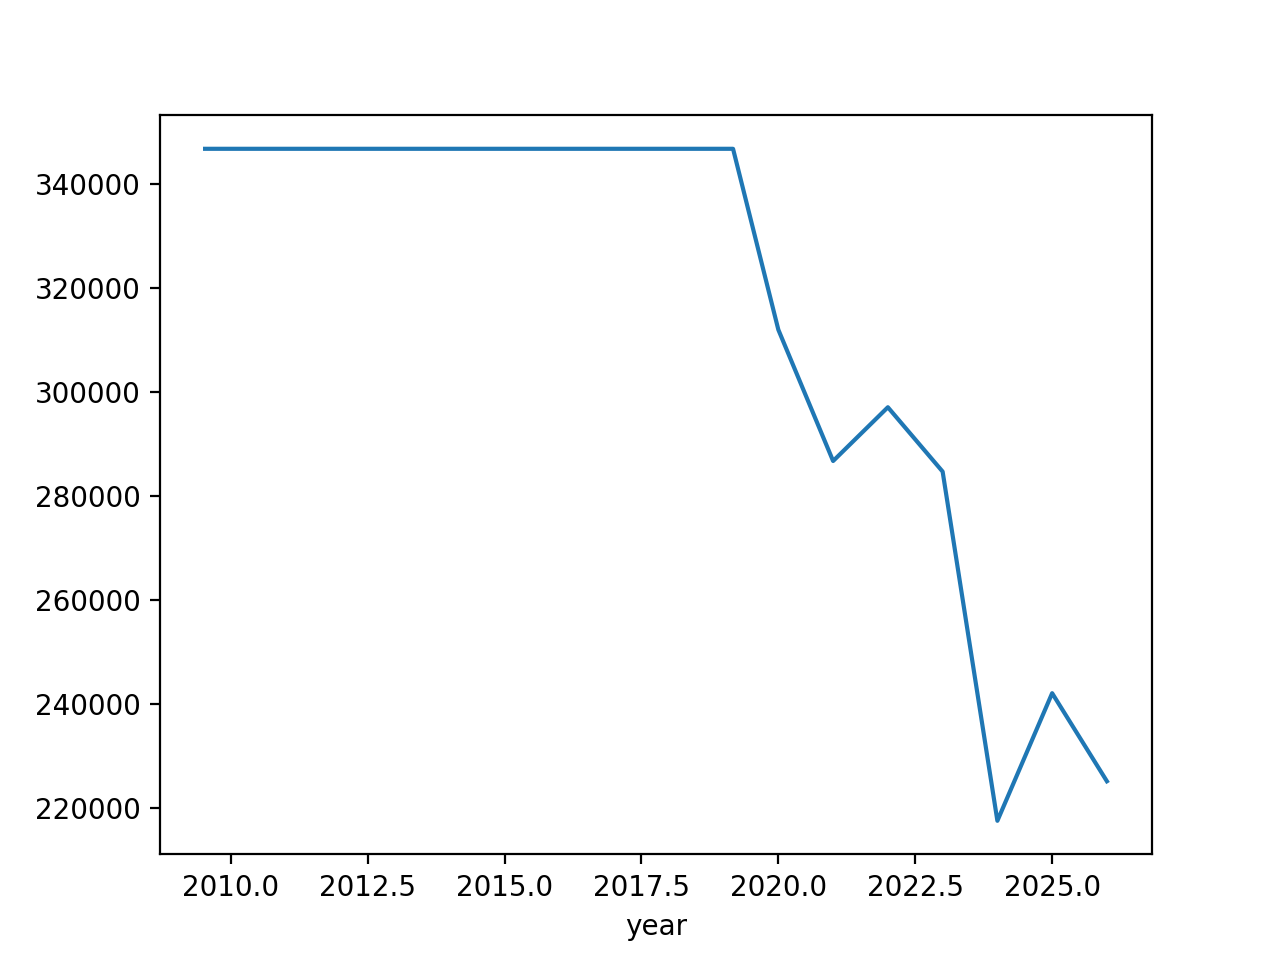

In [121]:
fluxdf.set_index('year')['fluxratio'].plot()
plt.show()